In [1]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext

conf = SparkConf().setAppName("sparkify").setMaster("local[*]").set(
    "spark.pyspark.virtualenv.enabled", "true")
sc = SparkContext.getOrCreate(conf=conf)

sc.install_pypi_package("pandas==0.25.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1683057429952_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


You are using pip version 9.0.1, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [26]:
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType
from pyspark.sql.functions import udf
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [28]:
spark = SparkSession.builder.master("local[*]").appName(
    "sparkify").getOrCreate()
# dataframe = spark.read.json("s3://csp-554-final-project/mini_sparkify_event_data.json")
dataframe = spark.read.json("./data/mini_sparkify_event_data.json")
dataframe.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)




[Stage 3806:>                                                       (0 + 8) / 8]



In [30]:
#Find count of null, none, NaN of all dataframe columns
from pyspark.sql.functions import col,isnan, when, count
dataframe.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataframe.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [31]:
print("The number of entries(rows) in the dataset: {}".format(dataframe.count()))
print("The number of features(columns) in the dataset: {}".format(len(dataframe.columns)))

The number of entries(rows) in the dataset: 286500
The number of features(columns) in the dataset: 18


In [32]:
#data cleaning
dataframe.select("page").dropDuplicates()
dataframe = dataframe.drop(*['artist', 'song', 'firstName', 'lastName','id_copy'])  
dataframe = dataframe.dropna(how='any',subset=['userId','sessionId'])  
dataframe = dataframe.filter(dataframe.userId != '').orderBy(["userId", "ts"], ascending=[True, True]) 
dataframe = dataframe.withColumn("userId", dataframe["userId"].cast(IntegerType())) 

In [33]:
cancel = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0,
                  IntegerType())
dataframe = dataframe.withColumn("churn", cancel("page"))
w = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding,
                                                   Window.unboundedFollowing)
dataframe = dataframe.withColumn("churn", Fsum("churn").over(w))

In [34]:
w1 = Window.partitionBy().orderBy(["userId", "ts"])
dataframe = dataframe.withColumn("level_shift", (dataframe.level != F.lag(dataframe.level).over(w1)) |
                   (dataframe.userId != F.lag(dataframe.userId).over(w1)))
dataframe = dataframe.fillna({'level_shift': 0})
dataframe = dataframe.withColumn("level_shift",
                   F.when(dataframe["level_shift"] == False, 0).otherwise(1))

In [35]:
dataframe = dataframe.withColumn(
    "ts", dataframe.ts /
    1000)  # trimming the last three zeros from the UNIX time (miliseconds)
dataframe = dataframe.withColumn("registration", dataframe.registration / 1000)

w2 = Window.partitionBy("userId")
dataframe = dataframe.withColumn("last_ts", F.max('ts').over(w2))
dataframe = dataframe.filter(
    dataframe.last_ts - dataframe.ts < 1300000
) 

In [36]:
dataframe.groupby('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|49719|
|     M|53562|
+------+-----+



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


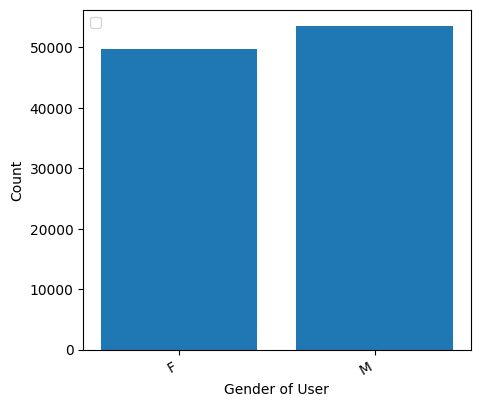

In [37]:
#Gender
gender_df = dataframe.groupby('gender').count().toPandas()
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(gender_df['gender'], gender_df['count'])
ax.set_ylabel('Count')
ax.set_xlabel('Gender of User')
ax.legend()
fig.autofmt_xdate()
plt.show()

In [38]:
dataframe.groupby('method').count().show()

+------+-----+
|method|count|
+------+-----+
|   PUT|95838|
|   GET| 7443|
+------+-----+



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


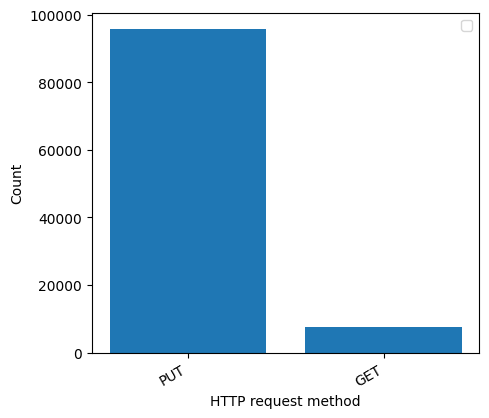

In [41]:
#Method
method_df = dataframe.groupby('method').count().toPandas()
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(method_df['method'], method_df['count'])
ax.set_ylabel('Count')
ax.set_xlabel('HTTP request method')
ax.legend()
fig.autofmt_xdate()
plt.show()

In [42]:
dataframe.groupby('status').count().show()

+------+-----+
|status|count|
+------+-----+
|   307| 8441|
|   404|   80|
|   200|94760|
+------+-----+



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


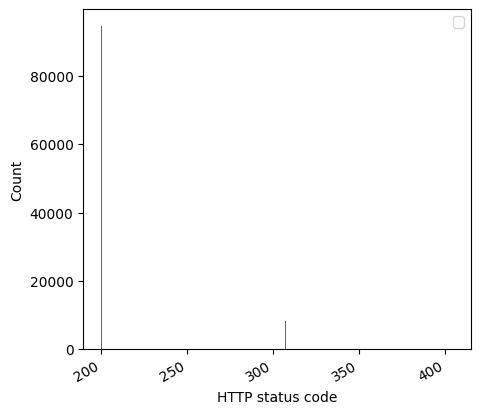

In [43]:
#Status
status_df = dataframe.groupby('status').count().toPandas()
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(status_df['status'], status_df['count'])
ax.set_ylabel('Count')
ax.set_xlabel('HTTP status code')
ax.legend()
fig.autofmt_xdate()
plt.show()

In [44]:
dataframe.groupby('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|16827|
| paid|86454|
+-----+-----+



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


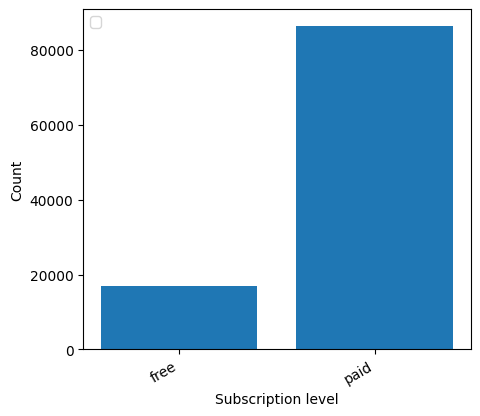

In [45]:
#Level
level_df = dataframe.groupby('level').count().toPandas()
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(level_df['level'], level_df['count'])
ax.set_ylabel('Count')
ax.set_xlabel('Subscription level')
ax.legend()
fig.autofmt_xdate()
plt.show()

In [46]:
dataframe.groupby('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|103229|
+---------+------+



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


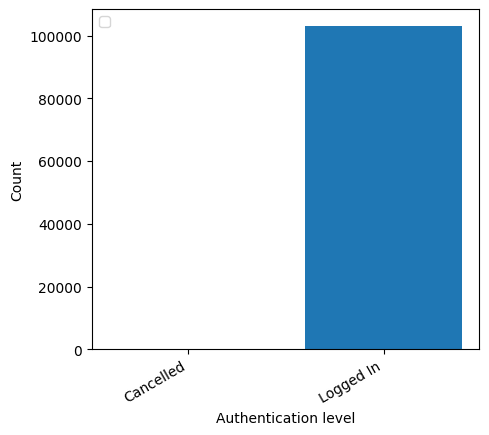

In [47]:
#Auth
auth_df = dataframe.groupby('auth').count().toPandas()
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(auth_df['auth'], auth_df['count'])
ax.set_ylabel('Count')
ax.set_xlabel('Authentication level')
ax.legend()
fig.autofmt_xdate()
plt.show()

In [48]:
dataframe.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|75545|
|    1|27736|
+-----+-----+



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


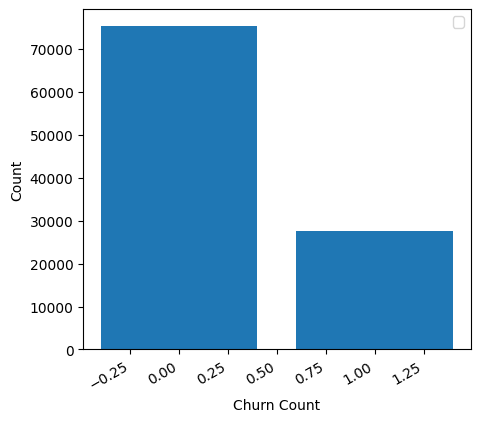

In [49]:
#Churn
churn_df = dataframe.groupby('churn').count().toPandas()
fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(churn_df['churn'], churn_df['count'])
ax.set_ylabel('Count')
ax.set_xlabel('Churn Count')
ax.legend()
fig.autofmt_xdate()
plt.show()

In [50]:
dataframe.groupby('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|    Submit Downgrade|   16|
|         Thumbs Down|  917|
|                Home| 3701|
|           Downgrade|  821|
|         Roll Advert| 1308|
|              Logout| 1201|
|       Save Settings|  126|
|Cancellation Conf...|   52|
|               About|  183|
|            Settings|  607|
|     Add to Playlist| 2380|
|          Add Friend| 1613|
|            NextSong|85017|
|           Thumbs Up| 4479|
|                Help|  537|
|             Upgrade|  154|
|               Error|   80|
|      Submit Upgrade|   37|
+--------------------+-----+



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


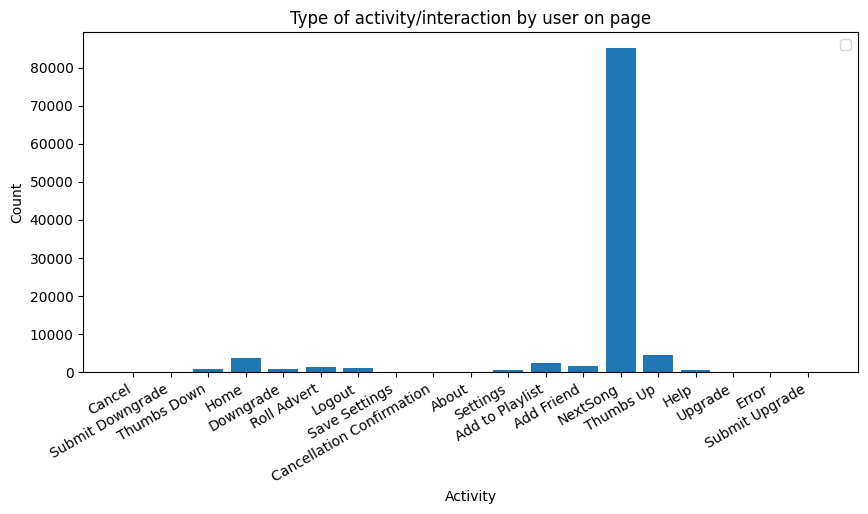

In [51]:
#Page
pages_df = dataframe.groupby('page').count().toPandas()
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(pages_df['page'], pages_df['count'])
ax.set_ylabel('Count')
ax.set_xlabel('Activity')
ax.set_title('Type of activity/interaction by user on page')
ax.legend()
fig.autofmt_xdate()
plt.show()

In [52]:
dataframe.describe('length').show()


[Stage 3967:>                                                       (0 + 8) / 8]



+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|             85017|
|   mean|249.21954353494107|
| stddev| 97.85934702365256|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



In [53]:
dataframe.groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|39231|
|    1|     M|17248|
|    1|     F|10488|
|    0|     M|36314|
+-----+------+-----+



In [54]:
dataframe.groupby(['churn', 'level']).count().show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    1| paid|22219|
|    1| free| 5517|
|    0| free|11310|
|    0| paid|64235|
+-----+-----+-----+



In [55]:
dataframe.groupby(['churn', 'method']).count().show()

+-----+------+-----+
|churn|method|count|
+-----+------+-----+
|    0|   GET| 5249|
|    0|   PUT|70296|
|    1|   GET| 2194|
|    1|   PUT|25542|
+-----+------+-----+



In [56]:
dataframe.groupby(['churn', 'status']).count().show()

+-----+------+-----+
|churn|status|count|
+-----+------+-----+
|    0|   307| 6144|
|    1|   307| 2297|
|    1|   404|   22|
|    0|   200|69343|
|    1|   200|25417|
|    0|   404|   58|
+-----+------+-----+



In [57]:
dataframe.groupby(['churn', 'page']).count().show(40)

+-----+--------------------+-----+
|churn|                page|count|
+-----+--------------------+-----+
|    0|       Save Settings|   94|
|    1|           Thumbs Up| 1169|
|    1|          Add Friend|  385|
|    1|     Add to Playlist|  647|
|    0|            Settings|  440|
|    0|          Add Friend| 1228|
|    1|             Upgrade|   54|
|    1|              Logout|  338|
|    1|    Submit Downgrade|    5|
|    1|         Thumbs Down|  301|
|    1|                Help|  140|
|    1|           Downgrade|  240|
|    1|               Error|   22|
|    0|               Error|   58|
|    0|                Help|  397|
|    0|         Thumbs Down|  616|
|    0|    Submit Downgrade|   11|
|    1|            Settings|  167|
|    0|            NextSong|62419|
|    0|           Downgrade|  581|
|    0|         Roll Advert|  840|
|    1|      Submit Upgrade|   15|
|    1|                Home| 1016|
|    1|         Roll Advert|  468|
|    0|      Submit Upgrade|   22|
|    1|             

In [8]:
w3 = Window.partitionBy(["userId", "sessionId"])
dataframe = dataframe.withColumn("pages_per_session", F.max('ItemInSession').over(w3))
dataframe = dataframe.withColumn("ts_time", F.to_timestamp(dataframe.ts)) 
dataframe = dataframe.withColumn("last_ts_time",
                   F.to_timestamp(dataframe.last_ts)) 

dataframe = dataframe.withColumn("diff_time", F.datediff(
    dataframe.last_ts_time, dataframe.ts_time)) 

dataframe = dataframe.orderBy(["userId", "ts"], ascending=[True, True])

dataframe.createOrReplaceTempView('data')

dataframe.select('page', 'UserId').groupby('page').agg({
    'page': 'count'
}).select('page', 'count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         16|
|         Thumbs Down|        917|
|                Home|       3701|
|           Downgrade|        821|
|         Roll Advert|       1308|
|              Logout|       1201|
|       Save Settings|        126|
|Cancellation Conf...|         52|
|               About|        183|
|            Settings|        607|
|     Add to Playlist|       2380|
|          Add Friend|       1613|
|            NextSong|      85017|
|           Thumbs Up|       4479|
|                Help|        537|
|             Upgrade|        154|
|               Error|         80|
|      Submit Upgrade|         37|
+--------------------+-----------+



In [9]:
fs = spark.sql("SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
round(avg(distinct pages_per_session),0)                                     as pages_per_session, \
round((max(ts) - min(registration))/86400,0)                                as duration, \
round(sum(level_shift),0)                                                  as level_shift, \
round(sum(length),0)                                                         as usage_time \
FROM data \
GROUP BY userId")

fs.createOrReplaceTempView('fs')
fs = fs.na.drop() 

In [10]:
# Train Test Split
train, val = fs.randomSplit([0.8, 0.2])
assembler = VectorAssembler(inputCols=["userId","song_count","error","friends","playlist_count", \
                                       "thumbs_up","thumbs_down","downgrade", "count_session_dist",\
                                       "count_diff_time","pages_per_session", "duration","level_shift",\
                                       "usage_time"], \
                            outputCol="inputFeatures")
scaler = Normalizer(inputCol="inputFeatures", outputCol="features")

algo1 = LogisticRegression()
algo2 = GBTClassifier()
algo3 = RandomForestClassifier()

p1 = Pipeline(stages=[assembler, scaler, algo1])
p2 = Pipeline(stages=[assembler, scaler, algo2])
p3 = Pipeline(stages=[assembler, scaler, algo3])

## Logistic Regression

In [13]:
pg =ParamGridBuilder()\
.addGrid(algo1.regParam, [0.0, 0,1])\
.addGrid(algo1.maxIter, [10])\
.build()

ev = MulticlassClassificationEvaluator(metricName="f1")
cv = CrossValidator(estimator=p1,
                          estimatorParamMaps=pg,
                          evaluator=ev,
                          numFolds=3)    

In [14]:
model1 = cv.fit(train)

23/05/03 21:26:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:26:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/05/03 21:26:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:26:33 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/03 21:27:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:27:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:27:56 WARN WindowExec: No Partition Defin

In [15]:
ev.evaluate(model1.transform(val))

23/05/03 21:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:28:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:28:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:28:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:28:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:28:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0.7008547008547008

## Gradient Boosted Tree Classifier

In [16]:
pg2 =ParamGridBuilder().build()
cv = CrossValidator(estimator=p2,
                          estimatorParamMaps=pg2,
                          evaluator=ev,
                          numFolds=3)

In [17]:
model2 = cv.fit(train)

23/05/03 21:30:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:30:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:31:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:31:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:32:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 2

In [18]:
ev.evaluate(model2.transform(val))

23/05/03 21:34:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:34:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:34:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:34:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:34:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:34:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0.8048048048048049

## Random Forest

In [19]:
pg3 =ParamGridBuilder().build()
cv = CrossValidator(estimator=p3,
                          estimatorParamMaps=pg3,
                          evaluator=ev,
                          numFolds=3)

In [20]:
model3 = cv.fit(train)

23/05/03 21:34:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:34:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:34:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:34:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:35:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:35:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 2

In [21]:
ev.evaluate(model3.transform(val))

23/05/03 21:35:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:35:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:35:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:35:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:35:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/05/03 21:35:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


0.7552447552447552